In [2]:
# Importações
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
# Carregar tabela
df = pd.read_csv('transacoes.csv')

In [4]:
# Converter 'data_hora' para datetime e ordenar
df['data_hora'] = pd.to_datetime(df['data_hora'])
df = df.sort_values(by=['id_cliente', 'data_hora']).reset_index(drop=True)

In [5]:
# Remover NaNs (sem imputação porque imputando os resultados estavam piorando muito)
df = df.dropna()

# Engenharia de feature:

In [6]:
# Feature 1: Número de transações nas últimas 24 horas
tqdm.pandas()

def conta_transacoes_24h(grupo):
    result = []
    for i in range(len(grupo)):
        limite = grupo.iloc[i]['data_hora'] - pd.Timedelta(hours=24)
        count = grupo[(grupo['data_hora'] >= limite) & (grupo['data_hora'] <= grupo.iloc[i]['data_hora'])].shape[0]
        result.append(count)
    return pd.Series(result, index=grupo.index)

df['transacoes_1D'] = df.groupby('id_cliente').progress_apply(conta_transacoes_24h).reset_index(level=0, drop=True)

100%|█████████████████████████████████████| 5930/5930 [00:03<00:00, 1713.95it/s]


In [7]:
# Feature 2: Tempo desde a última transação (em segundos)
def tempo_desde_ultima_transacao(grupo):
    tempo_ultima = grupo['data_hora'].shift(1)
    diff = grupo['data_hora'] - tempo_ultima
    return diff.dt.total_seconds()

df['tempo_desde_ultima'] = df.groupby('id_cliente').progress_apply(tempo_desde_ultima_transacao).reset_index(level=0, drop=True)
df['tempo_desde_ultima'].fillna(-1, inplace=True)  # Primeira transação do cliente


100%|█████████████████████████████████████| 5930/5930 [00:01<00:00, 4240.17it/s]


In [8]:
# Feature 3: Valor médio das transações anteriores
def valor_medio_anterior(grupo):
    return grupo['valor_transacao'].expanding().mean().shift(1)

df['valor_medio_anterior'] = df.groupby('id_cliente').progress_apply(valor_medio_anterior).reset_index(level=0, drop=True)
df['valor_medio_anterior'].fillna(df['valor_transacao'].median(), inplace=True)

100%|█████████████████████████████████████| 5930/5930 [00:00<00:00, 8819.35it/s]


In [9]:
# Feature 4: Origem e Destino Diferentes (1 se diferentes, 0 se iguais)
df['origem_destino_diferentes'] = (df['pais_origem'] != df['pais_destino']).astype(int)

In [10]:
# Preparação dos dados
def prep_data(df):
    selected_cols = ['valor_transacao', 'canal', 'categoria', 'pais_origem', 'pais_destino', 
                     'transacoes_1D', 'tempo_desde_ultima', 'valor_medio_anterior', 'origem_destino_diferentes']
    
    X = df[selected_cols]
    categorical_cols = ['canal', 'categoria', 'pais_origem', 'pais_destino']
    X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
    y = df['fraude'].values
    return X.values, y, X.columns.tolist()

X, y, col_names = prep_data(df)

In [11]:
# Balanceamento com SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)


In [12]:
# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

In [13]:
# Escalonamento
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Modelo: RandomForest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [15]:
# Previsão de probabilidades
y_proba = rf.predict_proba(X_test_scaled)[:, 1]

In [16]:
# Ajuste automático do threshold via ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
j_scores = tpr - fpr
best_threshold_index = np.argmax(j_scores)
best_threshold = thresholds[best_threshold_index]

print(f"Melhor threshold encontrado via ROC curve: {best_threshold:.4f}")

Melhor threshold encontrado via ROC curve: 0.6700


In [17]:
# Nova previsão com threshold otimizado
y_pred_best = (y_proba >= best_threshold).astype(int)

In [18]:
# Avaliação
print("\n=== Avaliação RandomForest com Novas Features ===")
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred_best))
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_best, digits=4))


=== Avaliação RandomForest com Novas Features ===
Matriz de Confusão:
[[2884    5]
 [  79 2810]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.9733    0.9983    0.9856      2889
           1     0.9982    0.9727    0.9853      2889

    accuracy                         0.9855      5778
   macro avg     0.9858    0.9855    0.9855      5778
weighted avg     0.9858    0.9855    0.9855      5778



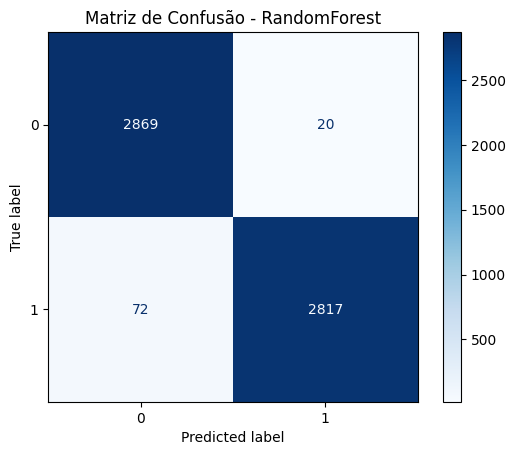

In [19]:

ConfusionMatrixDisplay.from_estimator(rf, X_test_scaled, y_test, cmap='Blues')
plt.title("Matriz de Confusão - RandomForest")
plt.grid(False)
plt.show()

In [20]:
# AUC-ROC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"AUC-ROC Score: {roc_auc:.4f}")

AUC-ROC Score: 0.9915


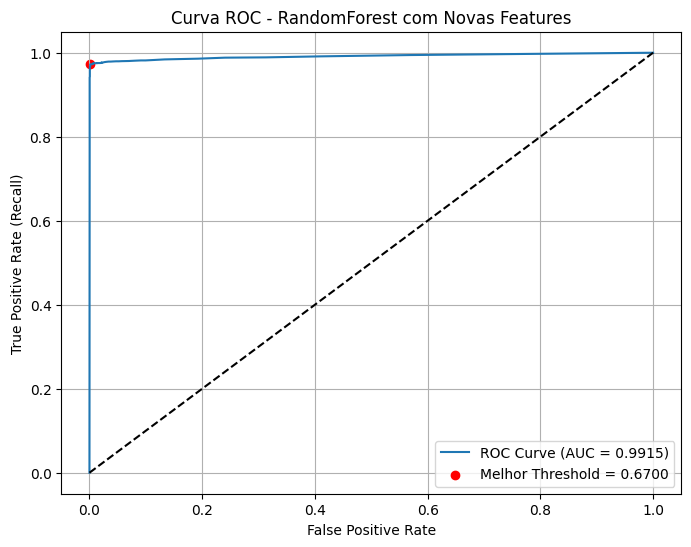

In [21]:
# Plot da Curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f'Melhor Threshold = {best_threshold:.4f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC - RandomForest com Novas Features')
plt.legend()
plt.grid(True)
plt.show()

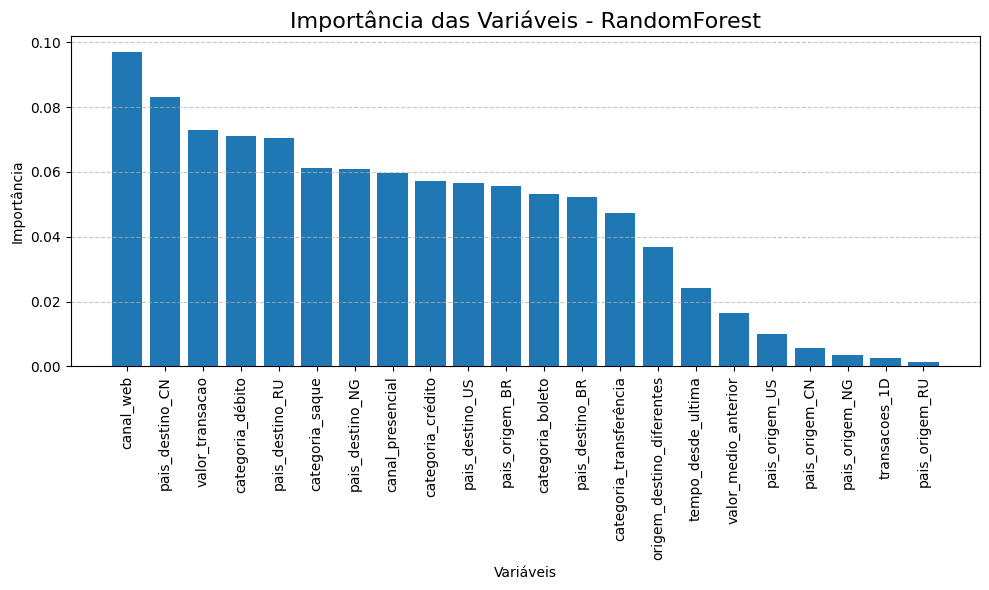

In [22]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]  # Ordem decrescente
feature_names = np.array(col_names)

# Plot
plt.figure(figsize=(10,6))
plt.title("Importância das Variáveis - RandomForest", fontsize=16)
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.ylabel("Importância")
plt.xlabel("Variáveis")
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()